Variational Autoencoder Implementation
==

In [1]:
%matplotlib inline
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from IPython.core.display import clear_output
import sys

In [2]:
def matmul(X, dout, name):
    with tf.variable_scope(name):
        _, dX = X.get_shape()
        W = tf.get_variable('W', shape=(dX, dout))
        b = tf.get_variable('b', shape=(dout))
    return tf.matmul(X, W)+b


def relu_layer(X, dout, name):
    return tf.nn.softplus(matmul(X, dout, name))


class VAE(object):
    def __init__(self, dX, dZ):
        self.enc_layers = [10,10]
        self.dec_layers = [10,10]
        self.dZ = dZ
        self.dX = dX

        self._build_network(dX, dZ)
        self._init_tf()

    def _build_network(self, dX, dZ):

        self.X = tf.placeholder(tf.float32, shape=(None, dX), name='X')
        self.noise = tf.placeholder(tf.float32, shape=(None, dZ), name='Z')
        self.lr = tf.placeholder(tf.float32, shape=tuple(), name='lr')

        # Encoding
        encoding = self.X
        with tf.variable_scope('encoder'):
            for i, layer_size in enumerate(self.enc_layers):
                encoding = relu_layer(encoding, layer_size, name='enc_%d'%i)
            # make mu, sigma
            self.mu = mu_enc = matmul(encoding, dZ, name='enc_mu')
            self.log_sigma = log_sigma_enc = matmul(encoding, dZ, name='enc_sig')
            self.sigma = sigma_enc = tf.exp(log_sigma_enc)

        #sigma_enc = tf.Print(sigma_enc, [sigma_enc])
        #mu_enc = tf.Print(mu_enc, [mu_enc])

        # Decoding
        enc_output = self.noise*tf.sqrt(sigma_enc) + mu_enc
        mu_dec, log_sigma_dec = self._decode(enc_output)
        self.mu_dec = mu_dec
        self.sigma_dec = sigma_dec = tf.exp(log_sigma_dec)
        
        # Sample decode
        self.sample_Z = tf.placeholder(tf.float32, shape=(None, dZ), name='Z_sample')
        self.sample_mu, self.sample_log_sigma = self._decode(self.sample_Z, reuse=True)
        self.sample_sigma = tf.exp(self.sample_log_sigma)
            
        # Losses
        # KL div btwn Q(z|x) and P(z)
        kldiv = tf.reduce_sum(self.sigma, reduction_indices=[1]) + \
                  tf.reduce_sum(tf.square(self.mu), reduction_indices=[1]) - \
                  tf.reduce_sum(tf.log(self.sigma), reduction_indices=[1])
        kldiv = tf.reduce_mean(kldiv) - dZ

        # log P(x|z)
        logpxz = -tf.reduce_sum(log_sigma_dec, reduction_indices=[1]) - \
                     tf.reduce_sum(tf.square(self.X - mu_dec)/sigma_dec, reduction_indices=[1])
        logpxz = tf.reduce_mean(logpxz)

        self.loss = kldiv - logpxz
        self.stepfn = tf.train.AdamOptimizer(self.lr).minimize(self.loss)
        
    def _decode(self, output, reuse=False):
        with tf.variable_scope('decoder', reuse=reuse):
            for i, layer_size in enumerate(self.enc_layers):
                output = relu_layer(output, layer_size, name='dec_%d'%i)
            mu_dec = matmul(output, dX, name='dec_mu')
            log_sigma_dec = (matmul(output, dX, name='dec_sig'))
        return mu_dec, log_sigma_dec

    def _init_tf(self):
        self.sess = tf.Session()
        self.sess.run(tf.initialize_all_variables())

    def step(self, X, lr=0.1):
        batch_size = X.shape[0]
        z = np.random.randn(batch_size, self.dZ)
        loss, _ = self.sess.run([self.loss, self.stepfn],
                feed_dict={ self.X: X, 
                            self.noise:z,
                            self.lr: lr})
        return loss

    def encode(self, X):
        mu, sigma = self.sess.run([self.mu, self.sigma],
                feed_dict={ self.X: X})
        return mu, sigma
    
    def encode_decode(self, X):
        batch_size = X.shape[0]
        z = np.random.randn(batch_size, self.dZ)
        mu, mu_dec, sigma_dec = self.sess.run([self.mu, self.mu_dec, self.sigma_dec],
                          feed_dict={self.X: X, self.noise:z})
        return mu, mu_dec, sigma_dec
    
    def sample(self, N):
        Z = np.random.randn(N, self.dZ)
        mu_dec, sigma_dec = self.sess.run([self.sample_mu, self.sample_sigma], {self.sample_Z: Z})
        return np.random.randn(N, self.dX) * np.sqrt(sigma_dec) + mu_dec
        

def flower_data(batch_size):
    z_true = np.random.uniform(0,1,batch_size)
    r = np.power(z_true, 0.5)
    phi = 0.25 * np.pi * z_true
    x1 = r*np.cos(phi)
    x2 = r*np.sin(phi)
    
    # Sampling form a Gaussian
    x1 = np.random.normal(x1, 0.10* np.power(z_true,2), batch_size)
    x2 = np.random.normal(x2, 0.10* np.power(z_true,2), batch_size)
        
    # Bringing data in the right form
    X = np.transpose(np.reshape((x1,x2), (2, batch_size)))
    X = np.asarray(X, dtype='float32')
    return X

def spiral_data(batch_size, spiral_rate=1.):
    T = 10
    t = np.random.uniform(size=batch_size, low=0, high=T)
    x = t*np.cos(t*spiral_rate)/T
    y = t*np.sin(t*spiral_rate)/T
    data = np.array([x,y]).T
    noise = np.random.randn(batch_size,2)/(T*2)
    return data+noise

Training & Test
===

In [3]:
sample_distribution = lambda x: spiral_data(x, spiral_rate=0.55)

In [4]:
#Training
tf.reset_default_graph()
np.random.seed(1)
dX = 2
dZ = 1
batch_size = 16
vae = VAE(dX, dZ)

tot_loss = 0
heartbeat = 100
losses = []
for i in range(10000):
    x = sample_distribution(batch_size)
    loss = vae.step(x, lr=1e-2)
    tot_loss += loss
    if i%heartbeat == 0:
        clear_output()
        print i, tot_loss/heartbeat
        losses.append(tot_loss/heartbeat)
        sys.stdout.flush()
        tot_loss = 0
        mus, sigmas = vae.encode(x)
        print np.mean(mus, axis=1)
        print np.mean(sigmas, axis=1)

9900 -3.34810314178
[-0.91058981 -1.82338142 -1.01120234 -0.86820424 -0.19584662 -0.66870999
 -0.00630587 -0.9145062  -0.22600335 -1.50159574 -0.6317634   0.12975413
 -0.74423242 -0.15766221 -0.55998909  0.82635587]
[ 0.00460796  0.04206112  0.00494448  0.00445095  0.0334447   0.00443132
  0.02284862  0.0049993   0.0247107   0.02144982  0.00534045  0.06675979
  0.0044092   0.0370786   0.00620473  0.12215219]


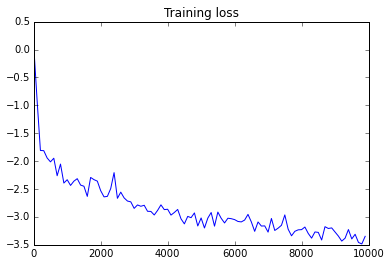

In [5]:
# Training plot
plt.title("Training loss")
plt.plot(np.arange(len(losses))*heartbeat, losses)
plt.show()

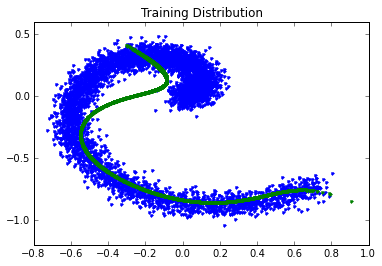

In [6]:
# Plot the original distribution
Nsamp = 5000
xx = sample_distribution(Nsamp)
plt.title('Training Distribution')
plt.plot(xx[:,0], xx[:,1],'.')

mu_enc, mu_dec, sigma_dec = vae.encode_decode(xx)
plt.plot(mu_dec[:,0], mu_dec[:,1], '.')  # Mean of VAE

plt.show()

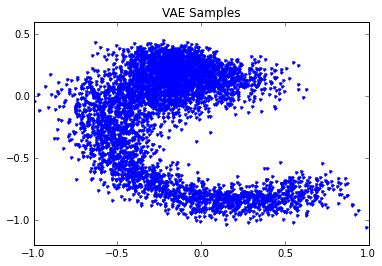

In [7]:
# Try sampling!
samples = vae.sample(5000)
plt.plot(samples[:,0], samples[:,1], '.') 
plt.title('VAE Samples')
plt.show()